In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import scipy.signal as scisignal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from dtw import *
import itertools
from scipy.signal import find_peaks, peak_prominences


index_to_aa = [c for c in 'CSAGTVNQMILYWFPHRKDE']
aa_to_index = {aa:i for i, aa in enumerate(index_to_aa)}
run_df = pd.read_json('./data/run_df.json')

run_to_peptide = {'20220824_run02_a': 'HDKER',
 '20220826_run01_a': 'GNQST',
 '20220826_run02_a': 'FYWCP',
 '20220826_run03_a': 'AVLIM',
 '20220907_run01_a': 'GNQST',
 '20221010_run02_a': 'GNQST',
 '20221011_run02_a': 'HDKER',
 '20221026_run01_a': 'VGDNY',
 '20221028_run01_a': 'TWAFH',
 '20221028_run02_a': 'PRMQE',
 '20221107_run01_a': 'TWAFH',
 '20221108_run01_a': 'TWAFH',
 '20221109_run01_a': 'VGDNY',
 '20221109_run02_a': 'PRMQE',
 '20221109_run03_a': 'KSILC',
 '20221109_run04_a': 'FYWCP',
 '20221110_run02_a': 'AVLIM',
 '20221121_run01_a': 'KSILC',
 '20221122_run01_a': 'KSILC',
 '20221122_run02_a': 'PRMQE',
 '20221122_run03_a': 'KSILC', 
 '20221213_run02_a': 'FYWCP',
 '20221214_run01_a': 'FYWCP',
 '20221214_run04_a': 'FYWCP',
 '20221219_run01_a': 'VGDNY',
 '20221220_run01_a': 'FYWCP',
 '20221220_run04_a': 'AVLIM',
 '20221221_run01_a': 'TWAFH',
 '20221221_run02_a': 'KSILC',
 }

## Filter and scale (transform)

In [71]:
transformed_signals_df = pd.DataFrame(columns=['run','channel','yy_offset','top_offset','transformed','raw','distance'])
verbose = False
b, a = scisignal.bessel(10, .03, 'low')
skip = 3

cnt = 1
transform_skip = 20
for run, row in run_df.iterrows():
    for chan in row['data'].keys():
        data = row['data'][chan]
        raw = data.copy()
        data = scisignal.filtfilt(b, a, data)
        skip = transform_skip
        data = np.array([sum(data[x:x+skip])/(len(data[x:x+skip])) for x in range(0,len(data), skip)])
        skip = 3
        meds = [np.median(data[i:min(len(data), i+skip)]) for i in range(0,len(data),skip)]
        chunk_size = int(len(meds)/10)
        yy_offset = np.median([min(meds[i:min(i+chunk_size,len(meds))]) for i in range(0,len(meds),chunk_size)])
        top_offset = np.median([max(meds[i:min(i+chunk_size,len(meds))]) for i in range(0,len(meds),chunk_size)])
        edited_signal = (data-yy_offset)/(top_offset-yy_offset)
        if verbose:
            plt.plot(data)
            plt.title(run)
            plt.show()
        transformed_signals_df.loc[len(transformed_signals_df.index)] = [run,float(chan), yy_offset,top_offset,edited_signal,raw,-1]


## Create artifical, pre-labeled signal to align to


### Each color will correspond to a segment (by its index in the signal). Each segment will be found and labeled in all other signals

/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_1772/117918892.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  labeled_ideal = transformed_signals_df[transformed_signals_df.channel==328][transformed_signals_df.run=='20221028_run01_a']['transformed'].values[0]


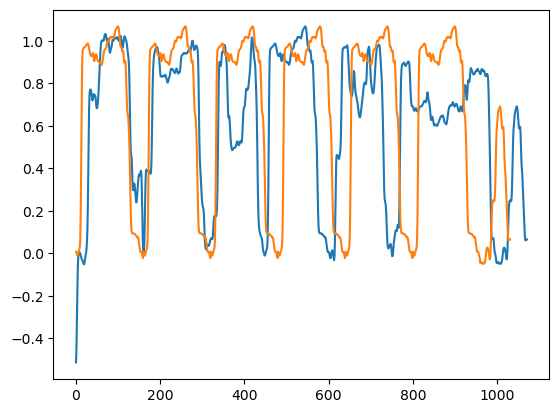

/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_1772/117918892.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('tab:orange')
/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_1772/117918892.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('tab:blue')
/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_1772/117918892.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('tab:cyan')


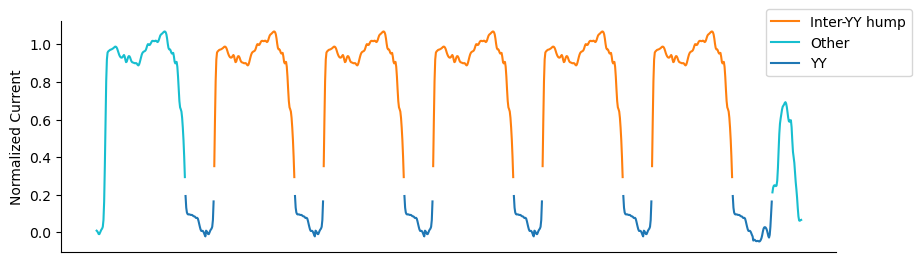

In [72]:
labeled_ideal = transformed_signals_df[transformed_signals_df.channel==328][transformed_signals_df.run=='20221028_run01_a']['transformed'].values[0]
plt.plot(np.concatenate([labeled_ideal]))
labeled_ideal = np.concatenate([list(labeled_ideal[445:605])*6, labeled_ideal[1000:]])
plt.plot(labeled_ideal)
plt.show()


figure(figsize=(10,3))
labels = [0, 130, 172, 290, 332, 450, 492, 610, 652, 770, 812, 930, 988, len(labeled_ideal)-1]

end = 0
colors = ['tab:cyan', 'tab:cyan', 'tab:blue',
          'tab:orange', 'tab:blue', 'tab:orange', 'tab:blue', 'tab:orange', 'tab:blue', 'tab:orange', 'tab:blue', 'tab:orange',
          'tab:blue', 'tab:cyan', 'tab:blue']
for i, (label, c) in enumerate(zip(labels, colors)):
    # color = 'blue' if i %2 ==0 else 'red'
    plt.plot([i for i in range(end,label)], [labeled_ideal[i] for i in range(end,label)], color=c)
    end = label
plt.ylabel('Normalized Current')
plt.legend(['Inter-YY hump', "Other", "YY"], bbox_to_anchor=(.9, 1.08))
plt.xticks([])
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
leg = ax.get_legend()
leg.legendHandles[0].set_color('tab:orange')
leg.legendHandles[1].set_color('tab:blue')
leg.legendHandles[1].set_color('tab:cyan')
plt.savefig(f"yy_segmentation.png", transparent=True , dpi=300, bbox_inches='tight')


## YY-segmentation

In [105]:
plotting = False
segments_df = pd.DataFrame(columns=['run','channel','raw','transformed','segment'])
for name, row in transformed_signals_df.iterrows():
    run = row.run
    chan = row.channel
    result = dtw(labeled_ideal, row.transformed)
    transformed_signals_df.at[name,'distance'] = result.normalizedDistance
    indexes = [np.where(result.index1 == l)[0][0] for l in labels]
    labels_other = [result.index2[idx] for idx in indexes]
    end = 0
    if plotting:
        figure(figsize=(20,6))
    
    raw_data = run_df['data'][run][str(float(chan))]
    for segment, label in enumerate(labels_other):
        if plotting:
            plt.plot([i for i in range(end,label)], [row.transformed[i] for i in range(end,label)])
            # plt.plot([i for i in range(end*20,label*20)], raw_data[end*20: label*20])
        segments_df.loc[len(segments_df.index)] = [row.run, row.channel, raw_data[end*20: label*20], row.transformed[end:label], segment] 
        end = label
    
    if plotting:
        plt.title(f"{row.run}  channel: {row.channel}")
        plt.ylim([-.5,2])
        plt.show()
        plt.close()


## Featurize and label

In [106]:
def get_aa(run, segment):
    if segment%2 == 0 or segment == 1:
        return ''
    idx = int((segment-3)/2)
    if idx > 4:
        return '' 
    return run_to_peptide[run][idx]
    
segments_df['aa'] = [''] * len(segments_df)
feature_cols = ['median', 'max', 'middle', 'mean_abs_deriv', 'median_abs_deriv','mean','raw_std', 'dip']

cnt = 0
    
for name, row in segments_df.iterrows():
    run = row.run
    chan = row.channel
    aa = get_aa(run, row.segment)
    if not aa:
        continue
    segments_df.at[name, 'median'] = np.median(row.transformed)
    segments_df.at[name, 'max'] = max(row.transformed)
    segments_df.at[name, 'aa'] = aa
    segments_df.at[name, 'mean_abs_deriv'] = np.mean([abs(d) for d in np.diff(row.transformed)])
    segments_df.at[name, 'median_abs_deriv'] = np.median([abs(d) for d in np.diff(row.transformed)])
    segments_df.at[name, 'mean'] = np.mean(row.transformed)
    segments_df.at[name, 'raw_std'] = np.std(row.raw)
    if np.isnan(segments_df.at[name, 'raw_std']):
        print(f"{name} has a nan raw std, raw has len: ", len(row.raw))

    x = row.transformed
    peaks, _ = find_peaks(x)
    prominences = peak_prominences(x, peaks)[0]

    zipped = [z for z in zip(peaks, prominences)]
    zipped.sort(key = lambda pair: pair[1])
    peaks = [p[0] for p in zipped[-2:]]
    smallest = min(x[min(peaks):max(peaks)]) if len(peaks) > 1 else max(x)

    segments_df.at[name, 'dip'] = x[peaks[0]]-smallest if len(prominences) >= 2 else 0
    segments_df.at[name, 'middle'] = smallest


## pairwise features

In [108]:
def run_pairwise_dtw(series, labels, channel=0):
    results = {}
    for ind1, signal1 in enumerate(series):
        for ind2, signal2 in enumerate(series[:ind1+1]):     
            result = dtw(signal1, signal2, distance_only=True)
            results[(labels[ind1], labels[ind2])] = result
            results[(labels[ind2], labels[ind1])] = result
    return results

# WARNING: ~20 min if runing pairwise
pretty_segments_df = segments_df[segments_df.aa != '']
pairwise_dtw_results_segments = run_pairwise_dtw(pretty_segments_df.transformed.values, pretty_segments_df.index.values)

results = pairwise_dtw_results_segments
channels_arr = list(set([x[0] for x in results.keys()] + [x[1] for x in results.keys()]))
dist_matrix = np.zeros(shape=(len(channels_arr), len(channels_arr)))
channel_to_aa = {chan : pretty_segments_df['aa'][chan] for chan in channels_arr}
for i, c1 in enumerate(channels_arr):
    for j, c2 in enumerate(channels_arr):
        dist_matrix[i][j] = results[(c1,c2)].normalizedDistance

dist_matrix_aa = np.zeros(shape=(20,20))
dist_matrix_cnts = np.zeros(shape=(20,20))
for key, val in results.items():
    aa_1 = aa_to_index[pretty_segments_df.aa[key[0]]]
    aa_2 = aa_to_index[pretty_segments_df.aa[key[1]]]
    dist_matrix_aa[aa_1][aa_2] += val.normalizedDistance
    dist_matrix_cnts[aa_1][aa_2] += 1

dist_matrix_div = dist_matrix_aa/dist_matrix_cnts

pretty_segments_df['features'] = [[0]]* len(pretty_segments_df)
for i, c in enumerate(channels_arr):
    pretty_segments_df['features'][c] = dist_matrix[i]

# save which channel corresponds to which index, so can later only use those in the training set
np.save(open('data/channels_arr.npy', 'wb'), channels_arr)


3360


/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_1772/1151788948.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretty_segments_df['features'] = [[0]]* len(pretty_segments_df)
/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_1772/1151788948.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretty_segments_df['features'][c] = dist_matrix[i]
